In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import ipywidgets as widgets
from ipywidgets import interact
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# 设置绘图风格
plt.style.use('default')
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号

## 1. 无空气阻力的抛体运动

初速度 $v_0 = 20\text{ m/s}$, 重力加速度 $g = 9.8\text{ m/s}^2$。
对于不同发射角 $\theta = 15^\circ, 30^\circ, 45^\circ, 60^\circ, 75^\circ$，绘制轨迹并验证 $\theta = 45^\circ$ 时射程最大。

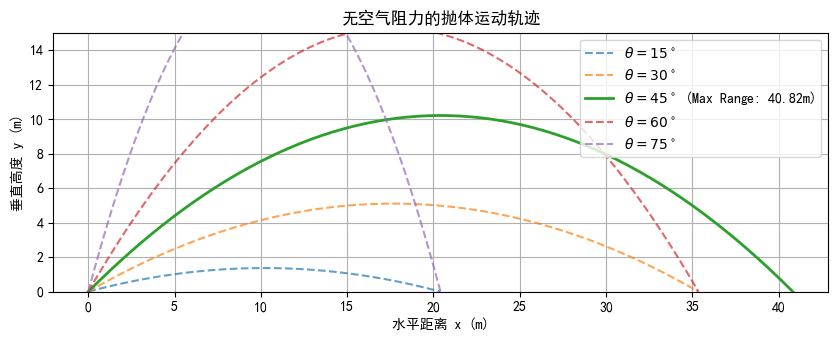

45度角时的射程: 40.8163 m


In [26]:
# 1. 无阻力计算与绘图
v0 = 20.0  # 初速度 (m/s)
g = 9.8    # 重力加速度 (m/s^2)
angles = [15, 30, 45, 60, 75]  # 发射角 (度)

def projectile_no_drag(v0, theta_deg, g=9.8):
    theta = np.deg2rad(theta_deg)
    t_flight = 2 * v0 * np.sin(theta) / g
    t = np.linspace(0, t_flight, 200)
    
    x = v0 * np.cos(theta) * t
    y = v0 * np.sin(theta) * t - 0.5 * g * t**2
    return x, y, max(x)

plt.figure(figsize=(10, 6))

max_range_45 = 0

for angle in angles:
    x, y, dist = projectile_no_drag(v0, angle, g)
    label = rf'$\theta={angle}^\circ$'
    if angle == 45:
        max_range_45 = dist
        label += f' (Max Range: {dist:.2f}m)'
        plt.plot(x, y, linewidth=2, label=label)
    else:
        plt.plot(x, y, linestyle='--', alpha=0.7, label=label)

plt.title('无空气阻力的抛体运动轨迹')
plt.xlabel('水平距离 x (m)')
plt.ylabel('垂直高度 y (m)')
plt.legend()
plt.grid(True)
# 使用 adjustable='box' 避免 "Ignoring fixed limits" 警告
plt.gca().set_aspect('equal', adjustable='box')
plt.ylim(0, 15)
plt.show()

print(f"45度角时的射程: {max_range_45:.4f} m")

## 2. 考虑空气阻力

阻力 $F_{drag} = -bv$。
令 $k = b/m$，取 $k = 0, 0.1, 0.3, 0.5$。

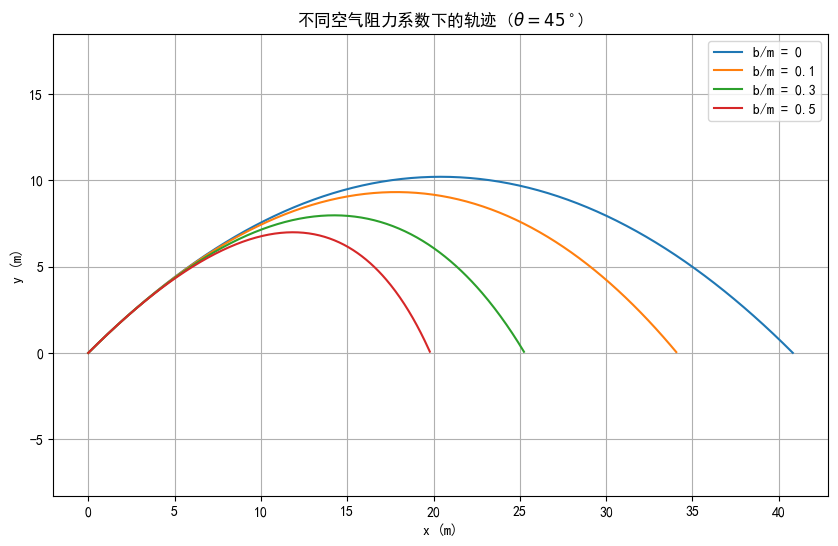

当 b/m = 0.3 时，最佳发射角约为: 39 度


In [27]:
def drag_equations(state, t, k, g=9.8):
    x, vx, y, vy = state
    dxdt = vx
    dvxdt = -k * vx
    dydt = vy
    dvydt = -g - k * vy
    return [dxdt, dvxdt, dydt, dvydt]

# 参数
m = 1.0
theta = 45
v0 = 20.0
k_values = [0, 0.1, 0.3, 0.5]

# 初始状态
angle_rad = np.deg2rad(theta)
vx0 = v0 * np.cos(angle_rad)
vy0 = v0 * np.sin(angle_rad)
state0 = [0, vx0, 0, vy0]  # x, vx, y, vy

t = np.linspace(0, 5, 500)  # 时间范围足够长以覆盖落地

plt.figure(figsize=(10, 6))

for k in k_values:
    # 求解微分方程
    sol = odeint(drag_equations, state0, t, args=(k, g))
    
    x = sol[:, 0]
    y = sol[:, 2]
    
    # 只取 y >= 0 的部分
    idx = np.where(y >= 0)[0]
    x_plot = x[idx]
    y_plot = y[idx]
    
    plt.plot(x_plot, y_plot, label=f'b/m = {k}')

plt.title(r'不同空气阻力系数下的轨迹 ($\theta=45^\circ$)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# 分析最佳发射角 (以 b/m = 0.3 为例)
k_test = 0.3
test_angles = range(30, 60)
max_r_k = 0
best_angle = 0

for ang in test_angles:
    rad = np.deg2rad(ang)
    s0 = [0, v0*np.cos(rad), 0, v0*np.sin(rad)]
    sol = odeint(drag_equations, s0, t, args=(k_test, g))
    y = sol[:, 2]
    x = sol[:, 0]
    
    # 找到落地点
    idx = np.where(y < 0)[0][0]
    if idx > 0:
        y1, y2 = y[idx-1], y[idx]
        x1, x2 = x[idx-1], x[idx]
        x_ground = x1 + (0 - y1) * (x2 - x1) / (y2 - y1)
        
        if x_ground > max_r_k:
            max_r_k = x_ground
            best_angle = ang

print(f"当 b/m = {k_test} 时，最佳发射角约为: {best_angle} 度")

## 3. 动画与能量分析

### 3.1 动画演示

**选项 A：交互式探索**
请调节滑块观察参数对轨迹的影响。

In [28]:
# 选项 A：交互式轨迹演示
def plot_interactive(v0=20, theta=45, k=0.1):
    plt.figure(figsize=(10, 6))
    
    t_sim = np.linspace(0, 10, 500)
    
    # Case 1: 无阻力
    # 注意：为了绘图方便，这里也用数值解，或者直接解析解
    rad = np.deg2rad(theta)
    s0 = [0, v0*np.cos(rad), 0, v0*np.sin(rad)]
    
    # 无阻力解析解
    x_no, y_no, _ = projectile_no_drag(v0, theta, g)
    # 过滤 py<0
    mask = y_no >= 0
    plt.plot(x_no[mask], y_no[mask], 'k--', label='无阻力', alpha=0.5)
    
    # Case 2: 有阻力
    sol = odeint(drag_equations, s0, t_sim, args=(k, g))
    x_drag = sol[:, 0]
    y_drag = sol[:, 2]
    mask_drag = y_drag >= 0
    
    plt.plot(x_drag[mask_drag], y_drag[mask_drag], 'r-', linewidth=2, label=f'有阻力 k={k}')
    
    plt.title(rf'交互演示: v0={v0} m/s, $\theta={theta}^\circ$, k={k}')
    plt.xlabel('距离 (m)')
    plt.ylabel('高度 (m)')
    plt.legend()
    plt.grid(True)
    # 使用 adjustable='box' 避免 "Ignoring fixed limits" 警告
    plt.gca().set_aspect('equal', adjustable='box')
    plt.ylim(0, 30)
    plt.xlim(0, 100)
    plt.show()

interact(plot_interactive, v0=(5.0, 50.0, 1.0), theta=(10, 85, 5), k=(0.0, 1.0, 0.1));

interactive(children=(FloatSlider(value=20.0, description='v0', max=50.0, min=5.0, step=1.0), IntSlider(value=…

**选项 C：竞速动画 (无阻力 vs 有阻力)**

In [29]:
# 选项 C：实时竞速动画
fig, ax = plt.subplots(figsize=(10, 6))
# 避免 Matplotlib 警告: "Ignoring fixed x limits..."
# 必须使用 adjustable='box' (调整图框大小) 或 'datalim' (调整数据限制)
# 这里选择 'box' 以保持我们设定的固定 x/y 范围
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(0, 50)
ax.set_ylim(0, 15)
ax.grid(True)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

line1, = ax.plot([], [], 'b--', label='无阻力')
point1, = ax.plot([], [], 'bo', markersize=8)
line2, = ax.plot([], [], 'r-', label='有阻力 (k=0.3)')
point2, = ax.plot([], [], 'ro', markersize=8)
ax.legend()
ax.set_title("竞速演示：无阻力 vs 有阻力 (v0=20, 45度)")

# 准备数据
t_anim = np.linspace(0, 4, 100)
theta_anim = 45
v0_anim = 20
rad_anim = np.deg2rad(theta_anim)
s0_anim = [0, v0_anim*np.cos(rad_anim), 0, v0_anim*np.sin(rad_anim)]

sol_no = odeint(drag_equations, s0_anim, t_anim, args=(0, 9.8))
sol_drag = odeint(drag_equations, s0_anim, t_anim, args=(0.3, 9.8))

def update(frame):
    # 无阻力
    if sol_no[frame, 2] >= 0:
        line1.set_data(sol_no[:frame, 0], sol_no[:frame, 2])
        point1.set_data([sol_no[frame, 0]], [sol_no[frame, 2]])
    
    # 有阻力
    if sol_drag[frame, 2] >= 0:
        line2.set_data(sol_drag[:frame, 0], sol_drag[:frame, 2])
        point2.set_data([sol_drag[frame, 0]], [sol_drag[frame, 2]])
    
    return line1, point1, line2, point2

anim = FuncAnimation(fig, update, frames=len(t_anim), interval=40, blit=True)
plt.close() # 隐藏静态图
HTML(anim.to_jshtml())

### 3.2 能量分析

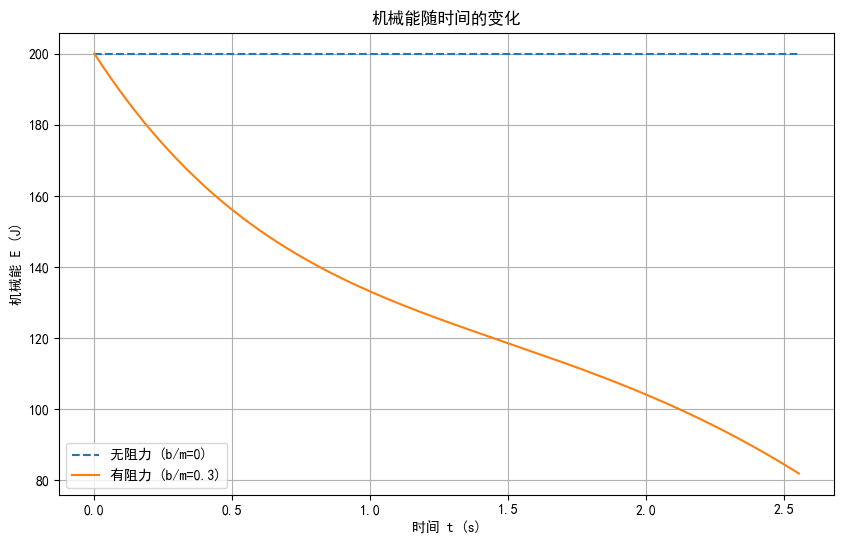

有阻力时能量损失: 59.07%


In [30]:
def calculate_energy(sol, m=1.0, g=9.8):
    vx = sol[:, 1]
    vy = sol[:, 3]
    y = sol[:, 2]
    v_sq = vx**2 + vy**2
    return 0.5 * m * v_sq + m * g * y

# 重新计算用于能量分析的数据
t_en = np.linspace(0, 5, 500)
sol_no_drag = odeint(drag_equations, state0, t_en, args=(0, g))
sol_drag = odeint(drag_equations, state0, t_en, args=(0.3, g))

E_no_drag = calculate_energy(sol_no_drag)
E_drag = calculate_energy(sol_drag)

idx1 = np.where(sol_drag[:, 2] >= 0)[0]

plt.figure(figsize=(10, 6))
plt.plot(t_en[:len(idx1)], E_no_drag[:len(idx1)], label='无阻力 (b/m=0)', linestyle='--')
plt.plot(t_en[idx1], E_drag[idx1], label='有阻力 (b/m=0.3)')
plt.title('机械能随时间的变化')
plt.xlabel('时间 t (s)')
plt.ylabel('机械能 E (J)')
plt.legend()
plt.grid(True)
plt.show()

loss = (E_drag[0] - E_drag[idx1[-1]]) / E_drag[0] * 100
print(f"有阻力时能量损失: {loss:.2f}%")